In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3 as sql3
import json
import sqlalchemy


In [2]:
# Entendimento do arquivo .geojson 
db = gpd.read_file("RJ.json")
atlas = pd.read_csv("atlas.csv")
db = db.drop(columns="description")
db["name"] = db["name"].str.lower()
municipios = db["name"].unique()

db

,id,name,geometry
0,3300100,angra dos reis,"POLYGON ((-44.19557 -23.09831, -44.19445 -23.1..."
1,3300159,aperibé,"POLYGON ((-42.11517 -21.60398, -42.11585 -21.6..."
2,3300209,araruama,"POLYGON ((-42.18220 -22.55217, -42.13226 -22.6..."
3,3300225,areal,"POLYGON ((-43.05873 -22.18937, -43.04773 -22.2..."
4,3300233,armação dos búzios,"POLYGON ((-41.93436 -22.76580, -41.91900 -22.7..."
...,...,...,...
87,3306008,três rios,"POLYGON ((-43.14554 -22.09725, -43.13612 -22.1..."
88,3306107,valença,"POLYGON ((-43.76557 -22.06243, -43.76344 -22.0..."
89,3306156,varre-sai,"POLYGON ((-41.75527 -20.80706, -41.75000 -20.8..."
90,3306206,vassouras,"POLYGON ((-43.45624 -22.21610, -43.43097 -22.2..."


<h1>Nova base de dados + Análise breve</h1>
<h3>Após entender como o geojson está separado uma nova base de dados será criada. Assim, neste trecho de código pegaremos apenas os anos de 2010 para a análise e a espectativa de vida com municípios.</h3>

In [130]:
atlas["município"] = atlas["município"].str.lower()
atlas_rj = atlas[atlas["município"].isin(municipios)]
atlas_rj_2010 = atlas_rj[atlas_rj["ano"] == 2010]
atlas_rj_2010 = atlas_rj_2010.drop_duplicates(subset=["município"])
merged = atlas_rj_2010.merge(db, left_on="município", right_on="name")

merged = gpd.GeoDataFrame(merged)
merged = merged[["id", "ano", "município", "espvida", "geometry"]]
merged["município"] = merged["município"].str.title()

merged

,id,ano,município,espvida,geometry
0,3305406,2010,Sapucaia,72.52,"POLYGON ((-42.70198 -21.99270, -42.69657 -22.0..."
1,3303104,2010,Natividade,75.81,"POLYGON ((-41.91271 -20.94044, -41.91815 -20.9..."
2,3300506,2010,Bom Jardim,69.98,"POLYGON ((-42.44684 -22.11704, -42.43790 -22.1..."
3,3306107,2010,Valença,71.65,"POLYGON ((-43.76557 -22.06243, -43.76344 -22.0..."
4,3301108,2010,Cantagalo,73.94,"POLYGON ((-42.23731 -21.69764, -42.22734 -21.7..."
...,...,...,...,...,...
87,3305901,2010,Trajano De Moraes,73.77,"POLYGON ((-42.15535 -22.00962, -42.14765 -22.0..."
88,3306008,2010,Três Rios,73.03,"POLYGON ((-43.14554 -22.09725, -43.13612 -22.1..."
89,3306156,2010,Varre-Sai,73.58,"POLYGON ((-41.75527 -20.80706, -41.75000 -20.8..."
90,3306206,2010,Vassouras,73.79,"POLYGON ((-43.45624 -22.21610, -43.43097 -22.2..."


<h1>Gráfico Simples</h1>
<h3>Após entender um pouco do que o arquivo .geojson contém, faremos um gráfico simples para conhecer melhor como a ferramente de plotagem com geopandas, e afins, funciona.</h3>

<AxesSubplot:>

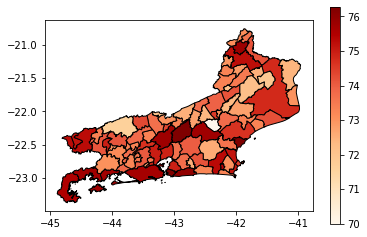

In [131]:
merged.plot(column='espvida', cmap='OrRd', edgecolor='k', legend=True)

<h1>Rearranjo do arquivo .geojson base</h1>
<h3>Apesar de conseguirmos plotar gráficos diretamente do geopandas o arquivo original não está formatado corretamente para seu uso com a biblioteca "Plotly". Com isso, pequenas modificações serão feitas para que o plotly consiga localizar os parâmetros de forma correta.</h3>

In [132]:
# Abrindo o arquivo .json
with open('RJ.json') as f:
  db_2 = json.load(f)

# Adicionando no local certo o id dos municípios para posterior uso
for i in range(db.index[-1] + 1):
  db_2["features"][i]["id"] = db_2["features"][i]["properties"]["id"]

# Exibição de teste para entendimento do dicionário json
db_2["features"][0]["properties"]

{'id': '3300100', 'name': 'Angra dos Reis', 'description': 'Angra dos Reis'}

<h1>Gráfico interativo</h1>
<h3>Agora que está tudo pronto uma análise interativa pode ser feita. Dessa forma, uma plotagem do tipo "Heatmap" da espectativa de vida de cada município será feita.</h3>

In [133]:
import plotly.express as px

fig = px.choropleth_mapbox(merged, geojson=db_2, locations="id", color='espvida',
                            hover_name="município",
                            color_continuous_scale="Viridis",
                            mapbox_style="carto-positron",
                            zoom=6, center = {"lat": -22.0, "lon": -42},
                            opacity=1,
                            title = "Espectativa de Vida",
                            labels={'espvida':'Anos'}
                            )
fig.show()

<h3>Apesar dos municípios terem discrepâncias em algumas características socioeconômicas, educacionais... a espectativa de vida como um todo não é tão discrepante, perceba que os valores estão entre 70~77 anos em média. </h3>

<h1>Possíveis correlações entre variados índices e indicadores</h1>
<h3><ul>
  <li>gini (Índice de Gini): Mede o grau de desigualdade existente na distribuição de indivíduos segundo a renda domiciliar per capita. Seu valor varia de 0, quando não há desigualdade (a renda domiciliar per capita de todos os indivíduos tem o mesmo valor), a 1, quando a desigualdade é máxima (apenas um indivíduo detém toda a renda).O universo de indivíduos é limitado àqueles que vivem em domicílios particulares permanentes.</li>
  <br>
  <li>i_escolaridade (Subíndice de escolaridade): Subíndice selecionado para compor o IDHMEducação, representando o nível de escolaridade da população adulta. É obtido pelo indicador % de jovens e adultos com 18 anos ou mais com o fundamental completo.</li>
  <br>
  <li>idhm (Índice de Desenvolvimento Humano Municipal): Média geométrica dos índices das dimensões Renda, Educação e Longevidade, com pesos iguais.</li>
  <br>
  <li>idhm_e (Índice de Desenvolvimento Humano Municipal - Dimensão Educação): Índice sintético da dimensão Educação que é um dos 3 componentes do IDHM. É obtido através da média geométrica do subíndice de frequência de crianças e jovens à escola, com peso de 2/3, e do subíndice de escolaridade da população adulta, com peso de 1/3.</li>
  <br>
  <li>idhm_l (Índice de Desenvolvimento Humano Municipal  - Dimensão Longevidade): Índice da dimensão Longevidade que é um dos 3 componentes do IDHM. É obtido a partir do indicador Esperança de vida ao nascer, através da fórmula: [(valor observado do indicador) - (valor mínimo)] / [(valor máximo) - (valor mínimo)], onde os valores mínimo e máximo são 25 e 85 anos, respectivamente.</li>
  <br>
  <li>idhm_r (Índice de Desenvolvimento Humano Municipal - Dimensão Renda): Índice da dimensão Renda que é um dos 3 componentes do IDHM. É obtido a partir do indicador Renda per capita, através da fórmula: [ln (valor observado do indicador) - ln (valor mínimo)] / [ln (valor máximo) - ln (valor mínimo)], onde os valores mínimo e máximo são R$ 8,00 e R$ 4.033,00 (a preços de agosto de 2010).</li>
</ul></h3>

In [143]:
import plotly.express as px
import plotly.graph_objects as go


db_para_corr = atlas.loc[:, "espvida":]
corr = db_para_corr.corr()

In [144]:
merged = atlas_rj_2010.merge(db, left_on="município", right_on="name")
merged = gpd.GeoDataFrame(merged)

merged = merged[["id", "ano", "município", "gini", "i_escolaridade",
                 "idhm", "idhm_e", "idhm_l","idhm_r", "geometry"]]

In [145]:
corr_1 = corr.loc[["gini", "i_escolaridade", "idhm", "idhm_e", "idhm_l","idhm_r"],
                  ["gini", "i_escolaridade", "idhm", "idhm_e", "idhm_l","idhm_r"]]


fig = go.Figure(data = go.Heatmap(
    z = corr_1.values,
    x = corr_1.index.values,
    y = corr_1.columns.values,
    colorscale="Mint",
    zmin=-0.3,
    zmax=1
))
fig.update_layout(title="Correlação com elementos da educação")
fig["layout"]["yaxis"]["autorange"] = "reversed"
fig.show()


<h3>Perceba que quanto maior cada índice, com excessão do de gini, maior será o indicador vizinho.Com isso, mostrando que a educação, a saúde e a economia são fatores primordiais e essenciais para a estabilidade e progresso de uma região.<br>
OBS: Veja que como o Índice Gini mede um grau de desigualdade é justo que a correlação entre os outros índices deja negativa, ou seja, inversamente proporcional de certa forma.</h3>

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-148-0ff4ca0c4b81>:40: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



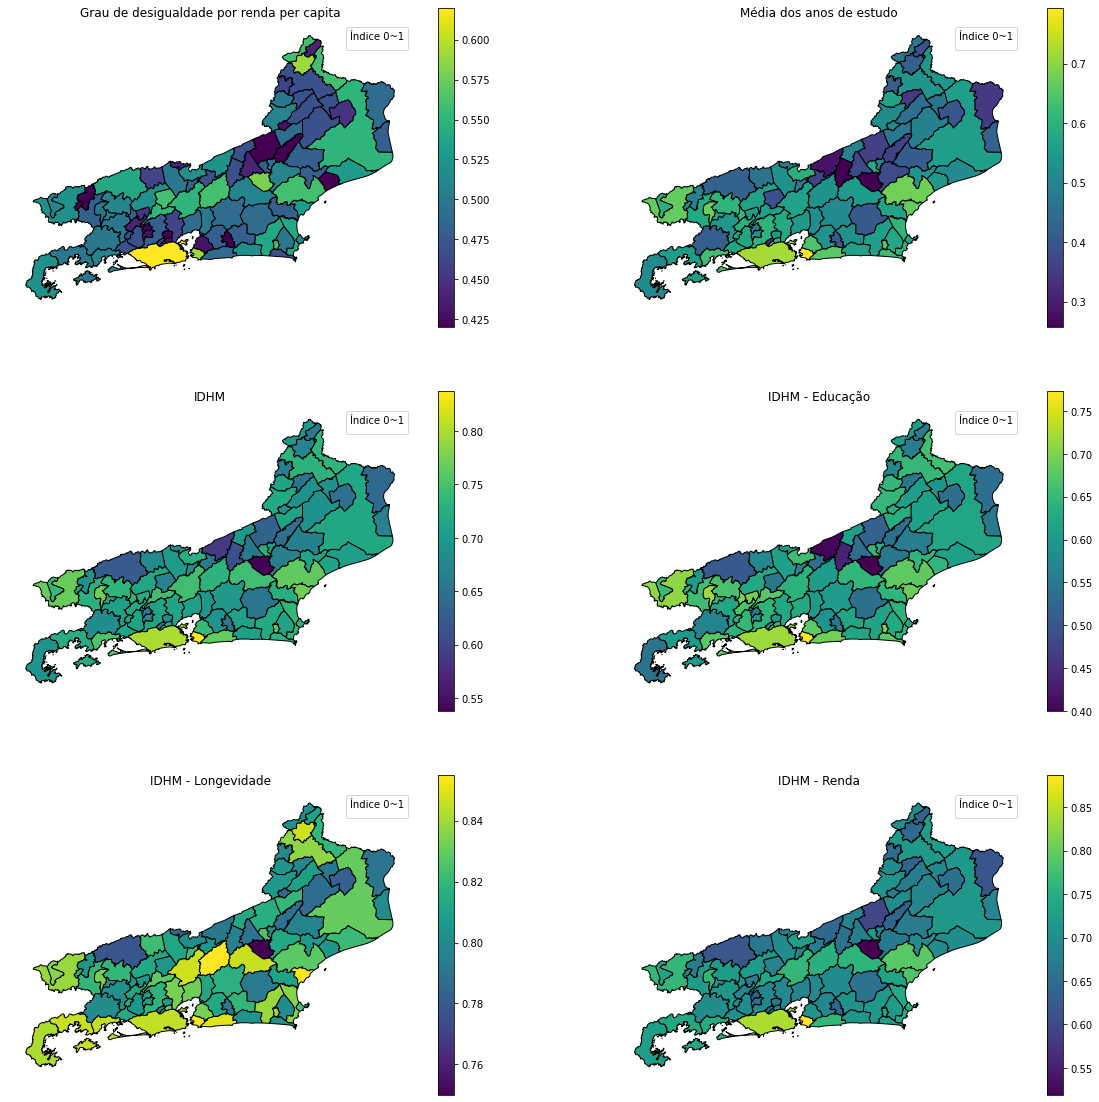

In [148]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,20))

merged.plot(column='gini', cmap='viridis', edgecolor='k', legend=True, ax = axes[0,0])
merged.plot(column='i_escolaridade', cmap='viridis', edgecolor='k', legend=True, ax = axes[0,1])
merged.plot(column='idhm', cmap='viridis', edgecolor='k', legend=True, ax = axes[1,0])
merged.plot(column='idhm_e', cmap='viridis', edgecolor='k', legend=True, ax = axes[1,1])
merged.plot(column='idhm_l', cmap='viridis', edgecolor='k', legend=True, ax = axes[2,0])
merged.plot(column='idhm_r', cmap='viridis', edgecolor='k', legend=True, ax = axes[2,1])


i = 0
j = 0
for i in range(3):
    for j in range(2):
        if i == 0 and j < 2:
            axes[i,j].legend(title = "Índice 0~1")
            axes[i,j].axis('off')
            if j == 0:
                axes[i,j].set_title('Grau de desigualdade por renda per capita')
            else:
                axes[i,j].set_title('Média dos anos de estudo')
        elif i == 1 and j < 2:
            axes[i,j].legend(title = "Índice 0~1")
            axes[i,j].axis('off')
            if j == 0:
                axes[i,j].set_title('IDHM')
            else:
                axes[i,j].set_title('IDHM - Educação')
        elif i == 2 and j < 2:
            axes[i,j].legend(title = "Índice 0~1")
            axes[i,j].axis('off')
            if j == 0:
                axes[i,j].set_title('IDHM - Longevidade')
            else:
                axes[i,j].set_title('IDHM - Renda')
        j += 1
    i += 1


fig.show()

Algum texto final